In [1]:
import os
from pathlib import Path
from os.path import join

# import pyproj
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd
import matplotlib.pyplot as plt
# import xugrid as xu
import xarray as xr

import hydromt
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel, utils
# from sfincs_utils import run_sfincs

proj = ccrs.PlateCarree() # plot projection

# Hydromt-sfincs approach for subgrid model

In [2]:
# select the model
sfincs_root = "z:/Code/COMPASS/sfincs_models/sfincs_MZ_ERA5"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r")

In [3]:
# first we are going to select our highest-resolution elevation dataset
depfile = join(sfincs_root, "subgrid", "dep_subgrid.tif")

da_dep = mod.data_catalog.get_rasterdataset(depfile)

In [4]:
# read global surface water occurance (GSWO) data to mask permanent water
mod.data_catalog.from_yml(os.path.normpath(os.path.join(os.path.dirname(os.path.abspath(sfincs_root)), '../COMPASS/SFINCS/sfincs_sofala/boundary_conditions/datacatalog.yml')))
gswo = mod.data_catalog.get_rasterdataset("gswo", geom=mod.region, buffer=1000)


In [6]:
# secondly we are reading in the model results
mod.read_results()

# as we have a subgrid model, we don't have hmax available, so we are using zsmax (maximum water levels)
# compute the maximum over all time steps
da_zsmax = mod.results["zsmax"].max(dim="timemax")

In [47]:
# thirdly, we determine the masking of the floodmap, which can be done in two ways

# most easy but less accurate is using a geodataframe (e.g. OpenStreetMap landareas) to mask water bodies
# NOTE: small rivers are not masked with this geodataframe
gdf_osm = mod.data_catalog.get_geodataframe("osm_landareas", geom=mod.region, buffer=10)

# we set a threshold to mask minimum flood depth
hmin = 0.05

# The second approach is masking using GSWO dataset to mask permanent water, which is done after obtained hmax

In [48]:
# Fourthly, we downscale the floodmap
# you can mask here using the osm land areas, or later with the more accurate gswo
da_hmax = utils.downscale_floodmap(
    zsmax=da_zsmax,
    dep=da_dep,
    hmin=hmin,
    # gdf_mask=gdf_osm, # uncommend for masking using OSM landareas
    # floodmap_fn=join(sfincs_root, "gis/floodmap.tif") # uncomment to save floodmap to <mod.root>/floodmap.tif
)

In [74]:
# we use the GSWO dataset to mask permanent water by first geprojecting it to the subgrid of hmax
gswo_mask = gswo.raster.reproject_like(da_hmax, method="max")

# permanent water where water occurence > 5%
da_hmax_masked = da_hmax.where(gswo_mask <= 5)

Text(0.5, 1.0, 'SFINCS masked maximum water depth')

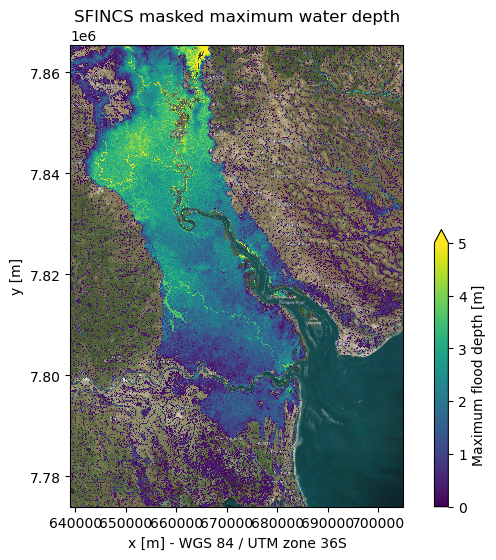

In [75]:
# Lastly, we create a basemap plot the masked hmax on top
fig, ax = mod.plot_basemap(
    fn_out=None, # join(sfincs_root, "gis/floodmap.tif")
    figsize=(8, 6),
    variable=da_hmax_masked,
    plot_bounds=False,
    plot_geoms=False,
    bmap="sat",
    zoomlevel=11,
    vmin=0,
    vmax=5.0,
    cbar_kwargs={"shrink": 0.6, "anchor": (0, 0)},
)
ax.set_title(f"SFINCS masked maximum water depth")
